#### Loading Dataset

In [1]:
import pandas as pd

df = pd.read_csv("dataset/online_retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Handle Null Values and add new columns

In [3]:
# Check for null values 
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# Remove all entries with null CustomerID 
df = df[df['CustomerID'].notnull()]

In [5]:
# ADD new column to store Total Price 
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

#### Data type conversions

In [6]:
# Convert InvoiceDate to Date Type 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


#### Analysis

In [8]:
# Determine last date for Retail Data
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [9]:
# Grouping For Recency ,Frequency, Monetary
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x : (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [10]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['rfm_score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,rfm_score
0,12346.0,326,2,0.00,1,2,1,4
1,12347.0,2,7,4310.00,5,4,5,14
2,12348.0,75,4,1797.24,2,3,4,9
3,12349.0,19,1,1757.55,4,1,4,9
4,12350.0,310,1,334.40,1,1,2,4


In [11]:
def segment(rfm):
    if rfm['rfm_score'] >= 12:
        return 'Champians'
    elif rfm['rfm_score'] >= 9:
        return 'Loyal Customers'
    elif rfm['rfm_score'] >= 7:
        return 'Potential Customers'
    elif rfm['rfm_score'] >= 4:
        return 'At Risk'
    else:
        return 'Lost'
    
rfm['Segment'] = rfm.apply(segment, axis=1)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,rfm_score,Segment
0,12346.0,326,2,0.00,1,2,1,4,At Risk
1,12347.0,2,7,4310.00,5,4,5,14,Champians
2,12348.0,75,4,1797.24,2,3,4,9,Loyal Customers
3,12349.0,19,1,1757.55,4,1,4,9,Loyal Customers
4,12350.0,310,1,334.40,1,1,2,4,At Risk


In [12]:
segment = rfm.groupby('Segment').agg({'CustomerID': 'count'})
segment

,CustomerID
Segment,
At Risk,1121
Champians,1279
Lost,198
Loyal Customers,1002
Potential Customers,772


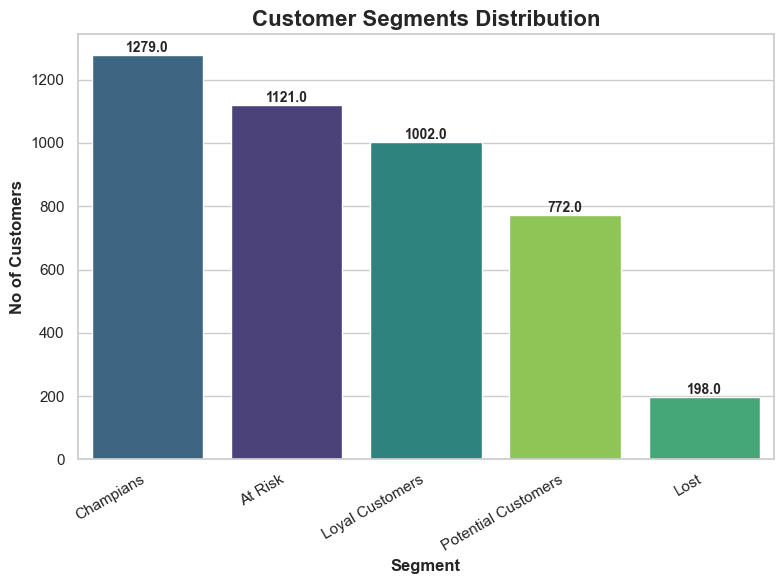

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
palette = sns.color_palette("viridis",  n_colors=rfm['Segment'].nunique())

ax = sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, hue='Segment', palette=palette, legend=False)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() /2., p.get_height()), ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.title("Customer Segments Distribution", fontsize=16, weight='bold')
plt.xlabel("Segment", fontsize=12, weight='bold')
plt.ylabel("No of Customers", fontsize=12, weight='bold')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()